# Домашнее задание "Сегментация и детекция объектов"

# The Nature Conservancy Fisheries Monitoring

https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring

In [1]:
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf

print(tf.__version__)

2.4.1


# Загружаем разметку

In [2]:
import os
import json
from glob import glob


def load_annotations():
    boxes = dict()              
    for path in glob('fish/boxes/*.json'):
        label = os.path.basename(path).split('_', 1)[0]
        with open(path) as src:
            for annotation in json.load(src):
                basename = os.path.basename(annotation['filename'])
                if label == "nof":                                                                     
                    annotation['filename'] = os.path.join("fish/train", 'NoF', basename)        
                else:
                    annotation['filename'] = os.path.join("fish/train", label.upper(), basename) 
                annotation['label'] = label #лейбл класса
                for rect in annotation['annotations']:
                    rect['x'] += rect['width'] / 2
                    rect['y'] += rect['height'] / 2
                if os.path.isfile(annotation['filename']):
                    boxes.setdefault(label, []).append(annotation)
    return boxes

def draw_boxes(annotation, rectangles=None, image_size=None):
    
    def _draw(img, rectangles, scale_x, scale_y, color=(0, 255, 0)):
        for rect in rectangles:
            pt1 = (int((rect['x'] - rect['width'] / 2) * scale_x),
                   int((rect['y'] - rect['height'] / 2) * scale_y))
            pt2 = (int((rect['x'] + rect['width'] / 2) * scale_x),
                   int((rect['y'] + rect['height'] / 2) * scale_y))
            img = cv2.rectangle(img.copy(), pt1, pt2, 
                                color=color, thickness=4)
        return img
    
    scale_x, scale_y = 1., 1.
    
    img = cv2.imread(annotation['filename'], cv2.IMREAD_COLOR)[...,::-1]
    if image_size is not None:
        scale_x = 1. * image_size[0] / img.shape[1]
        scale_y = 1. * image_size[1] / img.shape[0]
        img = cv2.resize(img, image_size)
        
    img = _draw(img, annotation.get('annotations', []), scale_x, scale_y) 
    
    if rectangles is not None:
        img = _draw(img, rectangles, 1., 1., (255, 0, 0))               

    return img

### Визуализируем разметку

In [3]:
boxes = load_annotations()  # загружаем разметку детекций

In [4]:
pd.DataFrame(
    [(k, len(v)) for k, v in boxes.items()],
    columns=['class', 'count'])

,class,count
0,alb,1719
1,bet,200
2,dol,117
3,lag,67
4,shark,176
5,yft,734


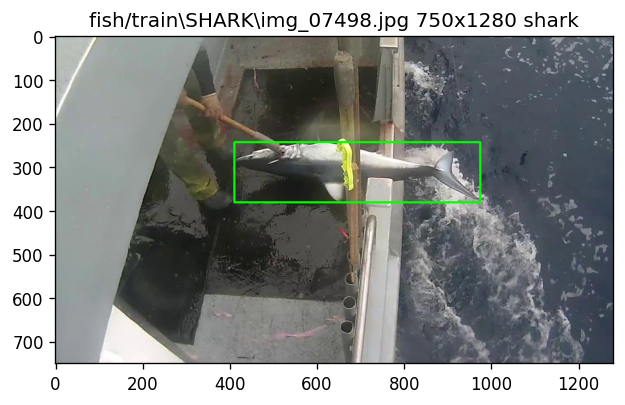

In [5]:
from matplotlib import pyplot as plt


annotation = boxes['shark'][6]
img = draw_boxes(annotation)

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(img)
plt.title('{} {}x{} {}'.format(annotation['filename'], img.shape[0], img.shape[1], annotation['label']));

### Распределение размеров разметки

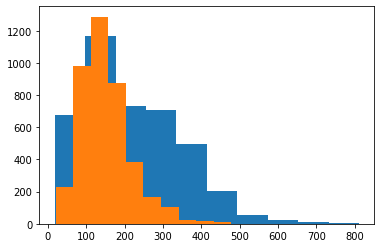

In [6]:
annotations = sum([box['annotations'] for box in sum(boxes.values(), [])], [])

widths = [rect['width'] for rect in annotations]
heights = [rect['height'] for rect in annotations]

plt.hist(widths)
plt.hist(heights);

# Экстрактор признаков

In [7]:
from tensorflow.keras.applications import vgg16

IMG_HEIGHT = 750
IMG_WIDTH = 1200

features = vgg16.VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# дообучаем последние 5 слоев
for layer in features.layers[:-5]:
    layer.trainable = False
    
feature_tensor = features.layers[-1].output
print(feature_tensor.shape)

(None, 23, 37, 512)


# Сетка якорей (anchor grid)

In [8]:
FEATURE_SHAPE = (feature_tensor.shape[1],
                 feature_tensor.shape[2])

GRID_STEP_H = IMG_HEIGHT / FEATURE_SHAPE[0]
GRID_STEP_W = IMG_WIDTH / FEATURE_SHAPE[1]

ANCHOR_WIDTH = 150.
ANCHOR_HEIGHT = 150. 

# сетка якорей, размер определяется соотношением 
# размера входного изображения и размером тензора признаков
ANCHOR_CENTERS = np.mgrid[GRID_STEP_H/2:IMG_HEIGHT:GRID_STEP_H,
                          GRID_STEP_W/2:IMG_WIDTH:GRID_STEP_W]

In [9]:
#  OHE
CLASSES = list(boxes.keys())                
CLASS_FEATURES = len(CLASSES)               
FRAME_FEATURES = 5                          
TOTAL_FEATURES = FRAME_FEATURES + CLASS_FEATURES  

def ohe_encode(label):             
    res = [0. for _ in range(len(CLASSES))]
    res[CLASSES.index(label)] = 1.
    return res

def ohe_decode_proba(lst):         
    return CLASSES[lst.index(max(lst))]

In [10]:
def iou(rect, x_scale, y_scale, anchor_x, anchor_y,
        anchor_w=ANCHOR_WIDTH, anchor_h=ANCHOR_HEIGHT):
    
    rect_x1 = (rect['x'] - rect['width'] / 2) * x_scale
    rect_x2 = (rect['x'] + rect['width'] / 2) * x_scale
    
    rect_y1 = (rect['y'] - rect['height'] / 2) * y_scale
    rect_y2 = (rect['y'] + rect['height'] / 2) * y_scale
    
    anch_x1, anch_x2 = anchor_x - anchor_w / 2, anchor_x + anchor_w / 2
    anch_y1, anch_y2 = anchor_y - anchor_h / 2, anchor_y + anchor_h / 2
    
    dx = (min(rect_x2, anch_x2) - max(rect_x1, anch_x1))
    dy = (min(rect_y2, anch_y2) - max(rect_y1, anch_y1))
    
    intersection = dx * dy if (dx > 0 and dy > 0) else 0.
    
    anch_square = (anch_x2 - anch_x1) * (anch_y2 - anch_y1)
    rect_square = (rect_x2 - rect_x1) * (rect_y2 - rect_y1)
    union = anch_square + rect_square - intersection
    
    return intersection / union

def encode_anchors(annotation, img_shape, class_features, iou_thr=0.5):
    encoded = np.zeros(shape=(FEATURE_SHAPE[0], FEATURE_SHAPE[1], TOTAL_FEATURES), dtype=np.float32) 
    x_scale = 1. * IMG_WIDTH / img_shape[1]     
    y_scale = 1. * IMG_HEIGHT / img_shape[0]    
    for rect in annotation['annotations']:      
        scores = []                             
        for row in range(FEATURE_SHAPE[0]):     
            for col in range(FEATURE_SHAPE[1]): 
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                score = iou(rect, x_scale, y_scale, anchor_x, anchor_y)
                scores.append((score, anchor_x, anchor_y, row, col))
        
        scores = sorted(scores, reverse=True)   
        if scores[0][0] < iou_thr:              
            scores = [scores[0]]                
        else:                                   
            scores = [e for e in scores if e[0] > iou_thr]

        for score, anchor_x, anchor_y, row, col in scores:
            dx = (anchor_x - rect['x'] * x_scale) / ANCHOR_WIDTH
            dy = (anchor_y - rect['y'] * y_scale) / ANCHOR_HEIGHT
            dw = (ANCHOR_WIDTH - rect['width'] * x_scale) / ANCHOR_WIDTH
            dh = (ANCHOR_HEIGHT - rect['height'] * y_scale) / ANCHOR_HEIGHT
            encoded[row, col] = [1., dx, dy, dw, dh] + class_features  
            
    return encoded

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def decode_prediction(prediction, conf_thr=0.1):
    rectangles = []
    for row in range(FEATURE_SHAPE[0]):                   
        for col in range(FEATURE_SHAPE[1]):
            logit, dx, dy, dw, dh = prediction[row, col][:FRAME_FEATURES]  
            cl = prediction[row, col][FRAME_FEATURES:]    
            conf = _sigmoid(logit)                        
            if conf > conf_thr:                           
                anchor_x = ANCHOR_CENTERS[1, row, col]    
                anchor_y = ANCHOR_CENTERS[0, row, col]
                rectangles.append({'x': anchor_x - dx * ANCHOR_WIDTH, 
                                   'y': anchor_y - dy * ANCHOR_HEIGHT,
                                   'width': ANCHOR_WIDTH - dw * ANCHOR_WIDTH,
                                   'height': ANCHOR_HEIGHT - dh * ANCHOR_HEIGHT,
                                   'cl': cl.tolist(),     
                                   'conf': conf})
    return rectangles

def non_max_suppression(rectangles, max_output_size, iou_threshold=0.5):
    if not rectangles:
        return rectangles
    
    boxes = [[r['y'],         
              r['x'],         
              r['y'] + r['height'],
              r['x'] + r['width']] for r in rectangles]
    scores = [r['conf'] for r in rectangles]
    indices = tf.image.non_max_suppression(np.array(boxes),
                                           np.array(scores),
                                           max_output_size,
                                           iou_threshold)
    
    return [rectangles[i] for i in indices]

### Валидация энкодинга/декодинга якорей

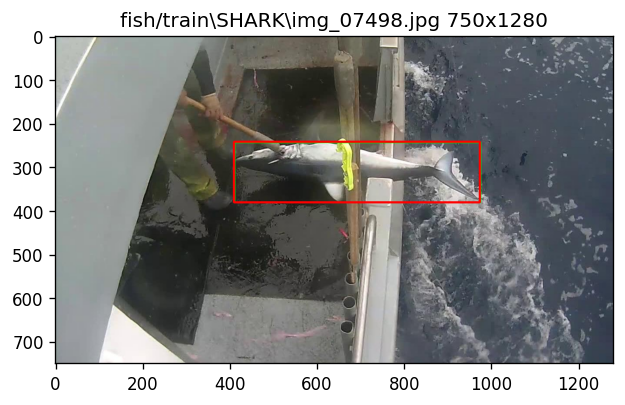

In [11]:
annotation = boxes['shark'][6]
class_features = ohe_encode(annotation['label']) 

encoded = encode_anchors(annotation, (IMG_HEIGHT, IMG_WIDTH), class_features, iou_thr=0.5)

decoded = decode_prediction(encoded, conf_thr=0.7)
decoded = sorted(decoded, key = lambda e: -e['conf'])

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(draw_boxes(annotation, decoded))
plt.title('{} {}x{}'.format(
    annotation['filename'], img.shape[0], img.shape[1]));

## Функция потерь

In [12]:
K = tf.keras.backend

def confidence_loss(y_true, y_pred):
    conf_loss = K.binary_crossentropy(y_true[..., 0], 
                                      y_pred[..., 0],
                                      from_logits=True)
    return conf_loss

def smooth_l1(y_true, y_pred):
    abs_loss = K.abs(y_true[..., 1:FRAME_FEATURES] - y_pred[..., 1:FRAME_FEATURES])             
    square_loss = 0.5 * K.square(y_true[..., 1:FRAME_FEATURES] - y_pred[..., 1:FRAME_FEATURES]) 
    mask = K.cast(K.greater(abs_loss, 1.), 'float32')
    total_loss = (abs_loss - 0.5) * mask + 0.5 * square_loss * (1. - mask)
    return K.sum(total_loss, axis=-1)

def classification_loss(y_true, y_pred):  ## функция потерь классификации
    class_loss = K.categorical_crossentropy(y_true[..., FRAME_FEATURES:], 
                                      y_pred[..., FRAME_FEATURES:],
                                      from_logits=True)
    return class_loss

def total_loss(y_true, y_pred, neg_pos_ratio=3):
    batch_size = K.shape(y_true)[0]
    
    # TODO: добавьте функцию потерь для классификации детекции
    
    y_true = K.reshape(y_true, (batch_size, -1, TOTAL_FEATURES))
    y_pred = K.reshape(y_pred, (batch_size, -1, TOTAL_FEATURES))

    # confidence loss
    conf_loss = confidence_loss(y_true, y_pred)
    
    # smooth l1 loss
    loc_loss = smooth_l1(y_true, y_pred)

    ## class loss
    class_loss = classification_loss(y_true, y_pred) ##
    #print(class_loss.shape)
    
    # positive examples loss
    pos_conf_loss = K.sum(conf_loss * y_true[..., 0], axis=-1)
    pos_loc_loss = K.sum(loc_loss * y_true[..., 0], axis=-1)
    pos_class_loss = K.sum(class_loss * y_true[..., 0], axis=-1) 
    
    # negative examples loss
    anchors = K.shape(y_true)[1]
    num_pos = K.sum(y_true[..., 0], axis=-1)
    num_pos_avg = K.mean(num_pos)
    num_neg = K.min([neg_pos_ratio * (num_pos_avg) + 1., K.cast(anchors, 'float32')])
    
    # hard negative mining
    neg_conf_loss, _ = tf.nn.top_k(conf_loss * (1. - y_true[..., 0]),
                                   k=K.cast(num_neg, 'int32'))

    neg_conf_loss = K.sum(neg_conf_loss, axis=-1)
    
    # total conf loss
    total_conf_loss = (neg_conf_loss + pos_conf_loss) / (num_neg + num_pos + 1e-32)
    loc_loss = pos_loc_loss / (num_pos + 1e-32)
    class_loss = pos_class_loss ##
    
    return total_conf_loss + 0.5 * loc_loss + class_loss

## Загрузка данных

In [13]:
from random import shuffle

def load_img(path, target_size=(IMG_WIDTH, IMG_HEIGHT)):
    img = cv2.imread(path, cv2.IMREAD_COLOR)[...,::-1]
    img_shape = img.shape
    img_resized = cv2.resize(img, target_size)
    return img_shape, vgg16.preprocess_input(img_resized.astype(np.float32))

def data_generator(boxes, batch_size=32):
    boxes = sum(boxes.values(), [])
    while True:
        shuffle(boxes)
        for i in range(len(boxes)//batch_size):
            X, y = [], []
            for j in range(i*batch_size,(i+1)*batch_size):
                img_shape, img = load_img(boxes[j]['filename'])
                
                class_features = ohe_encode(boxes[j]['label']) 
                
                y.append(encode_anchors(boxes[j], img_shape, class_features))
                X.append(img)
            yield np.array(X), np.array(y)

## Добавляем выход детектора

In [14]:
output = tf.keras.layers.BatchNormalization()(feature_tensor)

output = tf.keras.layers.Conv2D(11,
                                kernel_size=(1, 1), 
                                activation='linear',
                                kernel_regularizer='l2')(output)

model = tf.keras.models.Model(inputs=features.inputs, outputs=output)
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 750, 1200, 3)]    0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 750, 1200, 64)     1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 750, 1200, 64)     36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 375, 600, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 375, 600, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 375, 600, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 187, 300, 128)     0     

## Обучение

In [15]:
adam = tf.keras.optimizers.Adam(lr=3e-4, decay=1e-6)
model.compile(optimizer=adam, 
              loss=total_loss,
              metrics=[confidence_loss, classification_loss])

In [16]:
batch_size = 16 

gen = data_generator(boxes, batch_size=batch_size)
steps_per_epoch = sum(map(len, boxes.values()), 0) / batch_size

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'my_fishdetector.hdf5', 
    monitor='loss',
    verbose=1,  
    save_best_only=True, 
    save_weights_only=False,
    mode='auto',
    save_freq=100) 



In [17]:
# model.fit(gen, 
#           steps_per_epoch=steps_per_epoch,
#           epochs=15,
#           callbacks=[checkpoint])

## Результат работы детектора

In [18]:
# model.save_weights('fish/fishdetector_v7.hdf5')

In [19]:
# загружаю ранее обученные веса
model.load_weights('fish/my_fishdetector.hdf5')

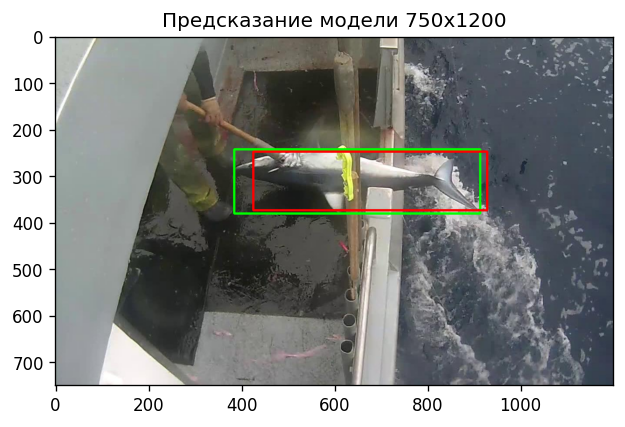

In [20]:
annotation = boxes['shark'][6]

_, sample_img = load_img(annotation['filename'])
pred = model.predict(np.array([sample_img,]))

decoded = decode_prediction(pred[0], conf_thr=0.05)
decoded = non_max_suppression(decoded,
                              max_output_size=2,
                              iou_threshold=0.05)

plt.figure(figsize=(6, 6), dpi=120)
img = draw_boxes(annotation, decoded, (IMG_WIDTH, IMG_HEIGHT))
plt.imshow(img)
plt.title('Предсказание модели {}x{}'.format(*img.shape));

## Визуализируем предсказание на тесте

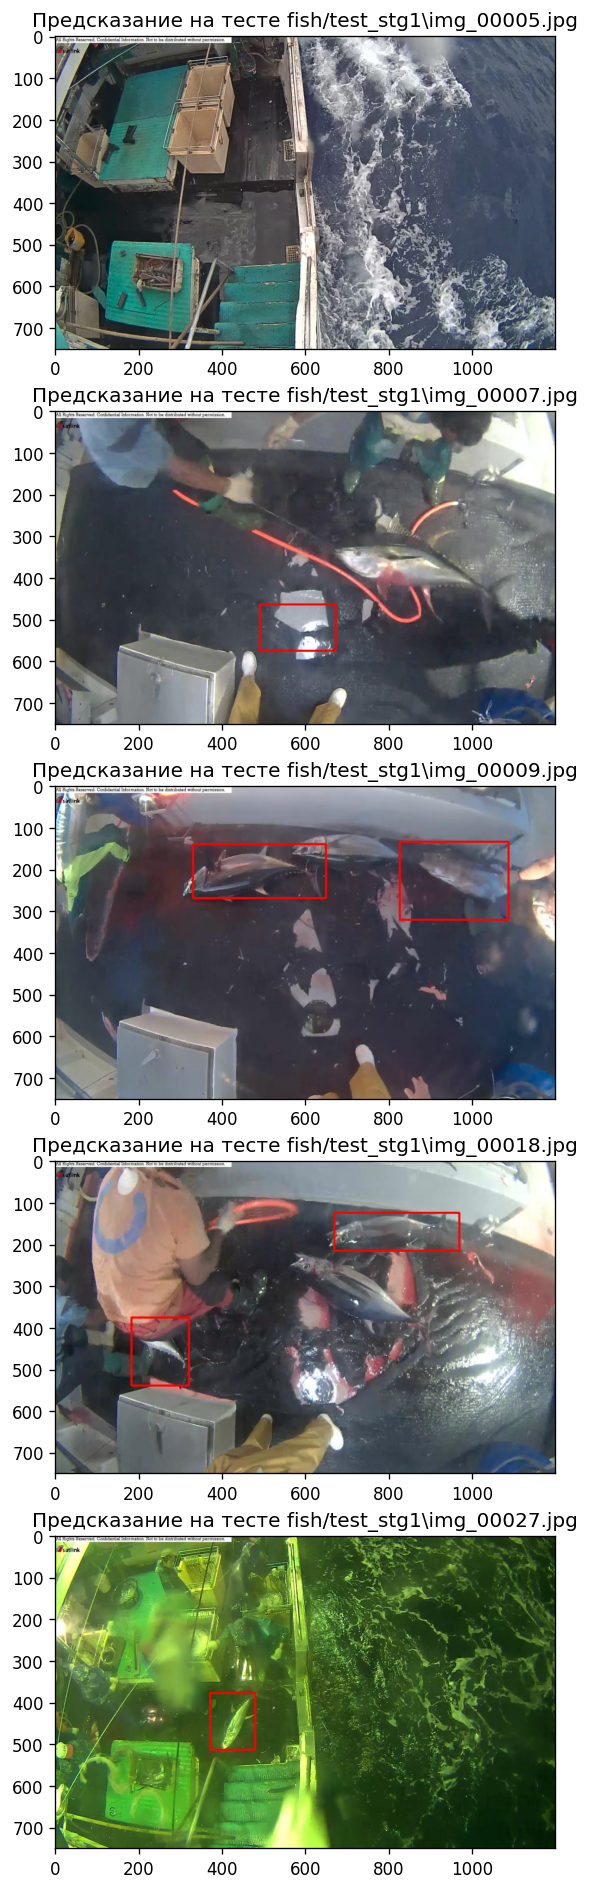

In [21]:
test_images = glob('fish/test_stg1/*.jpg')[:5]


plt.figure(figsize=(6, 4 * len(test_images)), dpi=120)

for i, filename in enumerate(test_images):
    _, sample_img = load_img(filename)
    pred = model.predict(np.array([sample_img,]))

    decoded = decode_prediction(pred[0], conf_thr=0.05)
    decoded = non_max_suppression(decoded,
                                  max_output_size=2,
                                  iou_threshold=0.05)
    
    plt.subplot(len(test_images), 1, i + 1)
    img = draw_boxes({'filename': filename}, decoded, (IMG_WIDTH, IMG_HEIGHT))
    plt.imshow(img)
    plt.title('Предсказание на тесте {}'.format(filename));

In [22]:
# Добавила 15 эпох, подкрутила трэшхолды, выгрузила на kaggle

## Агрегация результатов

In [23]:
def submission_save(TEST_PREFIX):
    images = []
    for path in glob(os.path.join(TEST_PREFIX, '*.jpg')):
        images.append(path)
    return images

In [24]:
test_stg1 = sorted(submission_save('fish/test_stg1'))
test_stg2 = sorted(submission_save('fish/test_stg2'))
nof = ["0.0", "0.0", "0.0", "0.0", "1.0", "0.0", "0.0", "0.0"]

In [ ]:
with open('fish/submition_v4.csv', 'w') as f:
    f.write('image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT\n')

    for filename in test_stg1:
        _, sample_img = load_img(filename)
        file_name = filename.split('/')[-1:]
        pred = model.predict(np.array([sample_img,]))

        decoded = decode_prediction(pred[0], conf_thr=0.05)
        decoded = non_max_suppression(decoded,
                                  max_output_size=2,
                                  iou_threshold=0.05)
        if len(decoded) == 0:
            f.write(f"{''.join(file_name)}, {','.join(nof)}\n")
        else:
            f.write(f"{''.join(file_name)}, {str(list(decoded[0]['cl']))[1:-1]}\n")

    for filename in test_stg2:
        _, sample_img = load_img(filename)
        file_name = '/'.join(filename.split('/')[-2:])
        pred = model.predict(np.array([sample_img,]))

        decoded = decode_prediction(pred[0], conf_thr=0.05)
        decoded = non_max_suppression(decoded,
                                  max_output_size=2,
                                  iou_threshold=0.05)
        if len(decoded) == 0:
            f.write(f"{''.join(file_name)}, {','.join(nof)}\n")
        else:
            f.write(f"{''.join(file_name)}, {str(list(decoded[0]['cl']))[1:-1]}\n")

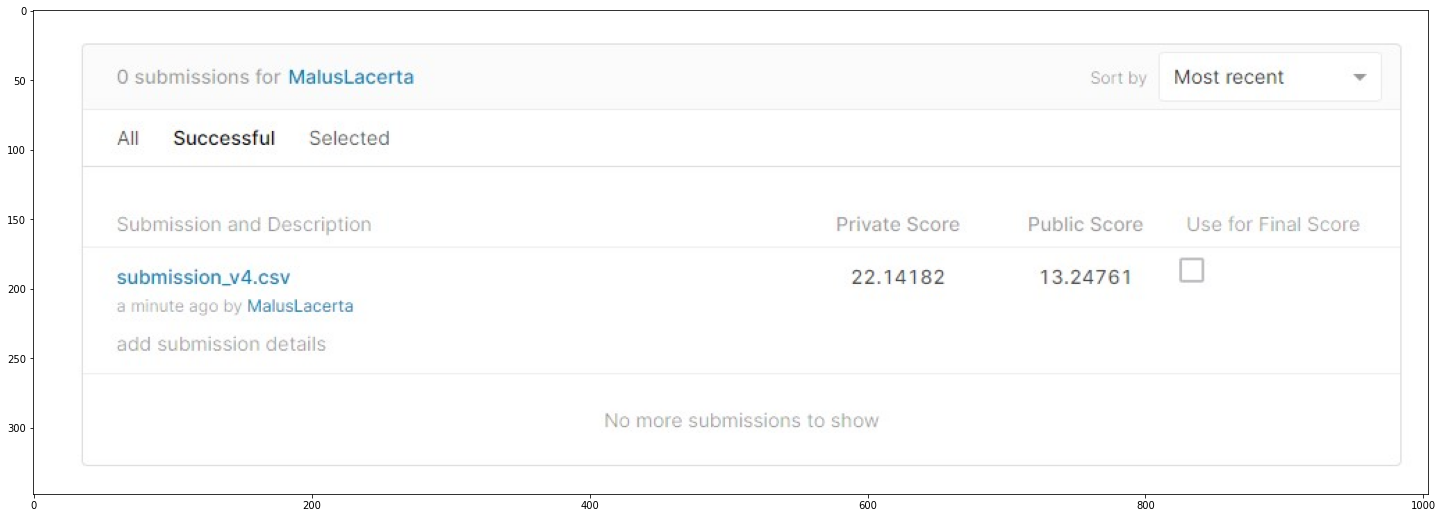

In [29]:
img_cv = cv2.imread('fish/fish_score.jpg')
plt.figure(figsize=(25, 15))
plt.imshow(img_rgb)
plt.show()